# Computer Vision Case Study: Creating an Application


### What did we learn about our application?

* Image Capture
    * Reduce glare from the blue leds
    * Increase exposure
    * Video Feed?
    
    
* Image Processing Steps (and parameters)
    * read image (filepath)
    * view image
    * crop (slice, slice)
    * separate channels
    * combine channels to isolate green flourescent particles (weights + offset)
    * histogram equalization
    * Gaussian filtering (kernel size?)
    * histogram equalization
    * Otsu threshold
    * morphological closing (kernel?, iterations?)
    * morphological opening (kernel?, iterations?)
    * labeling (structure?)
    * display labels and particle count
    

## Classes

How can we break this application down into classes?

What kinds of coding objects do work with?

Main application class: Labeler

Utility classes
* Image
* Channel
* Particle


## Particle Labeling Classes

To facilitate embedded use in a device, the next step is to consolidate these procedures into a class.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy import ndimage


class Channel():
    
    def __init__(self, data):
        self.data = data
    
    @property
    def histogram(self):
        return cv.calcHist([self.img], [0], None, [256], [0, 255])
    
    def imshow(self, ax=None, title=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(self.img, cmap="gray")
        if not title is None:
            ax.set_title(title)
        
    def display_histogram(self, ax, color='k'):
        bins = np.arange(0, 256)
        ax.plot(bins, self.histogram, color=color)
        

class Particle():
    
    def __init__(self, x, y, slice):
        self.x = x
        self.y = y
        self.slice = slice
        a, b = slice
        self.xmin = b.start
        self.ymin = a.start
        self.xmax = b.stop
        self.ymax = a.stop
        
    def size(self):
        return np.sqrt((self.xmax - self.xmin) * (self.ymax - self.ymin))
        
    def bounding_box(self):
        return (self.xmin, self.xmax, self.xmax, self.xmin, self.xmin), \
               (self.ymin, self.ymin, self.ymax, self.ymax, self.ymin)


class ParticleLabeler():
    
    def __init__(self, filepath=None):
        self.filepath = filepath
        self.channels = dict()
        self.particles = list()
        if not filepath is None:
            self.imread(filepath)
            
    @property
    def particle_count(self):
        return len(self.particles)

    def imread(self, filepath):
        """Read image from given filepath."""
        self.filepath = filepath
        b, g, r = cv.split(cv.imread(filepath))
        self.channels['r'] = Channel(r)
        self.channels['g'] = Channel(g)
        self.channels['b'] = Channel(b)
        
    def imshow(self, ax=None, rgb=('r','g','b')):
        """Display image on given plot axis using specified rgb channels."""
        r, g, b = rgb
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(np.dstack((self.channels[r].img, 
                             self.channels[g].img,
                             self.channels[b].img)))
        
    def display_histogram(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        for color, channel in self.channels.items():
            channel.display_histogram(ax, color=color)
            
    def composite(self, rgb_weights={'r':1, 'g':1, 'b':1}, dst='k'):
        composite = sum([rgb_weights[c]*self.channels[c].img for c in rgb_weights.keys()])
        composite = np.where(composite < 0, 0, composite)
        self.channels[dst] = Channel(composite.astype(np.uint8))
        
    def threshold(self, src='k', dst='k', r=71):
        blurred = cv.medianBlur(self.channels[src].img, r)
        T, img =  cv.threshold(blurred, 0, 255, cv.THRESH_OTSU)
        self.channels[dst] = Channel(img)
        
    def adaptive_threshold(self, src='k', dst='k'):
        blurred = cv.medianBlur(self.channels[src].img, 5)
        img = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 101, 10)
        self.channels[dst] = Channel(img)
        
    def label(self, src='k'):
        img = self.channels[src].img
        labels, particle_count = ndimage.measurements.label(img, structure=np.ones((3, 3)))
        yx_pts = ndimage.center_of_mass(img, labels, np.arange(1, particle_count + 1))
        slices = ndimage.find_objects(labels)
        self.particles = [Particle(yx[1], yx[0], slice) for yx, slice in zip(yx_pts, slices)]
        
    def find_particles(self, filepath, size=(50, 150), ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 12))
        self.imread(filepath)
        self.composite({'g':1, 'b':-0.53}, 'k')
        self.threshold(src='k', dst='k')
        self.label(src='k')
        self.imshow(ax)

        k = 0
        for p in labeler.particles:
            if p.size() > 50 and p.size() < 150:
                k += 1
                x, y = p.bounding_box()
                ax.plot(x, y, 'w')
                ax.plot([p.x], [p.y], 'r.', ms=5)
                ax.text(p.x + 40, p.y - 40, f"{k}", color='white')

In [122]:
help(Channel)

Help on class Channel in module __main__:

class Channel(builtins.object)
 |  Channel(img)
 |  
 |  A class to represent one channel of a multi-channel image.
 |  ...
 |  
 |  Attributes
 |  ----------
 |  img :
 |  
 |  Methods defined here:
 |  
 |  __init__(self, img)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  display_histogram(self, ax, color='k')
 |  
 |  imshow(self, ax=None, title=None)
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  histogram
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



46


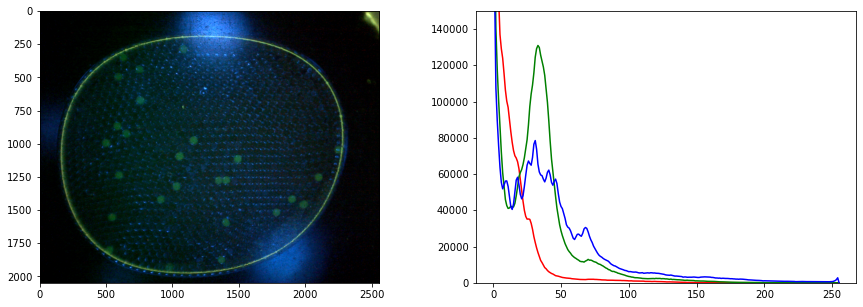

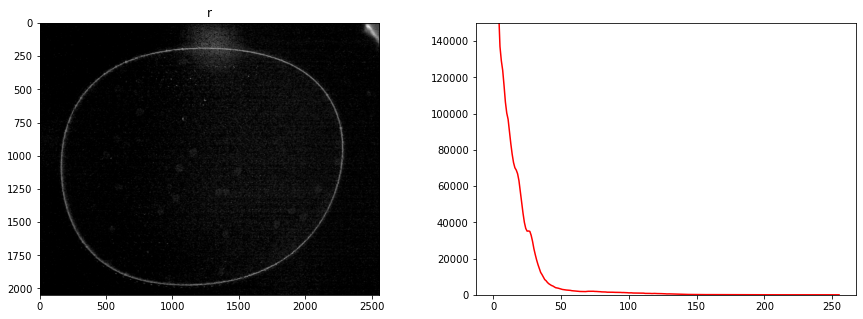

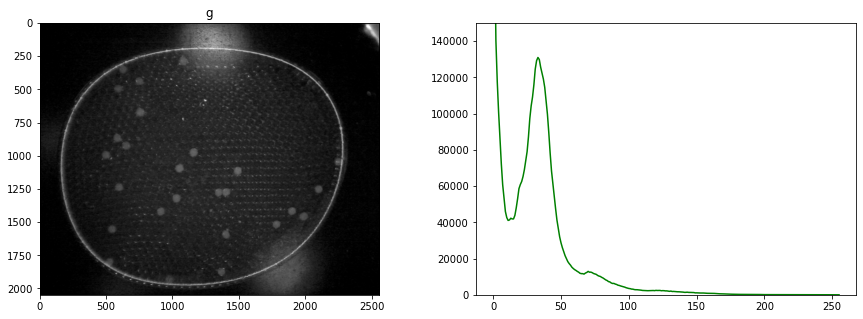

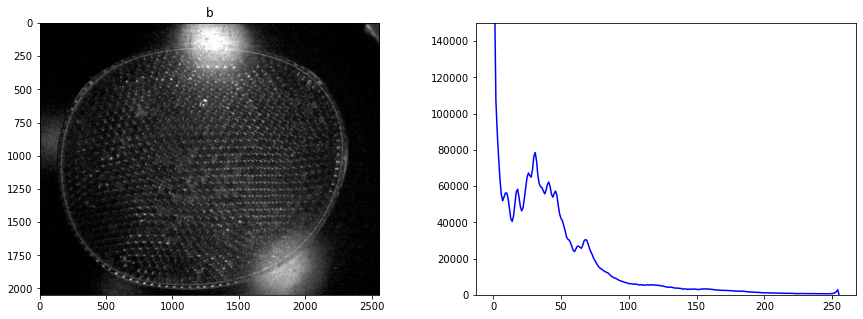

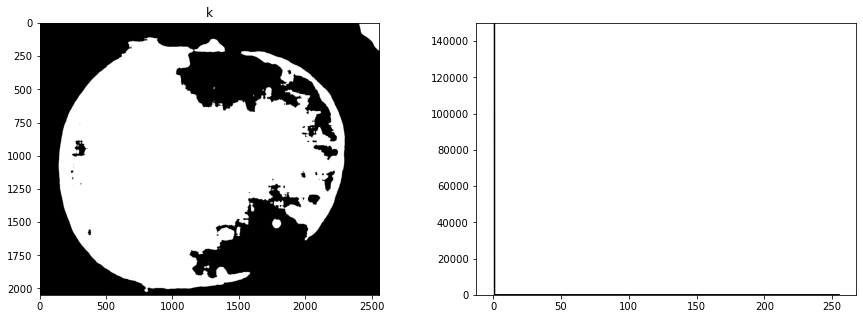

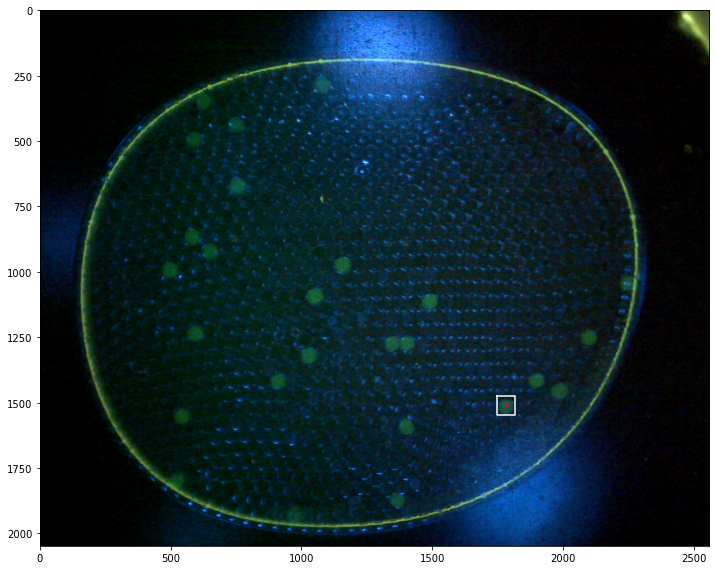

In [106]:
# TESTING

# create labeler instance
labeler = ParticleLabeler()

# read image file
labeler.imread("data/25-miniM.tif")

# display image and histogram
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
labeler.imshow(ax[0])
labeler.display_histogram(ax[1])
ax[1].set_ylim(0, 150000)

# make composite channel
labeler.composite({'g':1, 'b':-0.53}, 'k')

# threshold
labeler.threshold(src='k', dst='k')

# label
labeler.label(src='k')
print(labeler.particle_count)

# display all channels
for color, channel in labeler.channels.items():
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    channel.imshow(ax[0], color)
    channel.display_histogram(ax[1], color=color)
    ax[1].set_ylim(0, 150000)
    
fix, ax = plt.subplots(1, 1, figsize=(12,10))
labeler.imshow(ax)
for p in labeler.particles:
    if p.size() > 50 and p.size() < 150:
        x, y = p.bounding_box()
        ax.plot(x, y, 'w')
        ax.plot([p.x], [p.y], 'r.', ms=5)

## Demonstrations

46


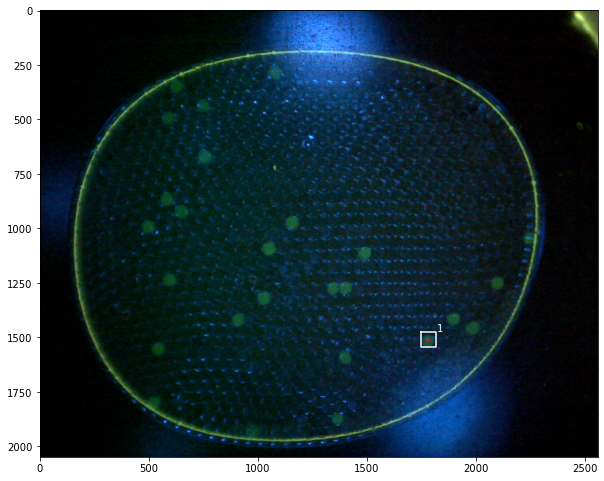

In [107]:
labeler = ParticleLabeler()
labeler.find_particles("data/25-miniM.tif", size=(50, 150))
print(labeler.particle_count)

Text(0.5, 1.0, 'Threshold = 80.0')

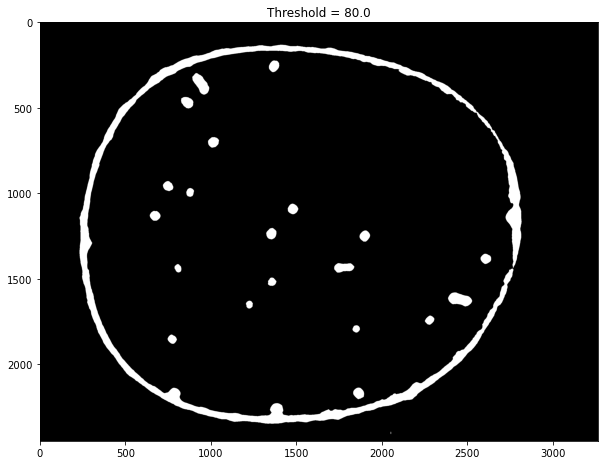

In [113]:
img = labeler.channels['g'].img
fimg = cv.GaussianBlur(img, (71, 71), 0)
fimg = cv.medianBlur(img, 51)
T, timg = cv.threshold(fimg, 80, 255, cv.THRESH_BINARY)
#T, timg = cv.threshold(fimg, 0, 255, cv.THRESH_OTSU)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))
#ax.imshow(img, cmap="gray")
#ax.imshow(img, cmap="gray")
ax.imshow(timg, cmap="gray")
ax.set_title(f"Threshold = {T}")
#ax.imshow(edges, cmap="hot", alpha=0.8)

34


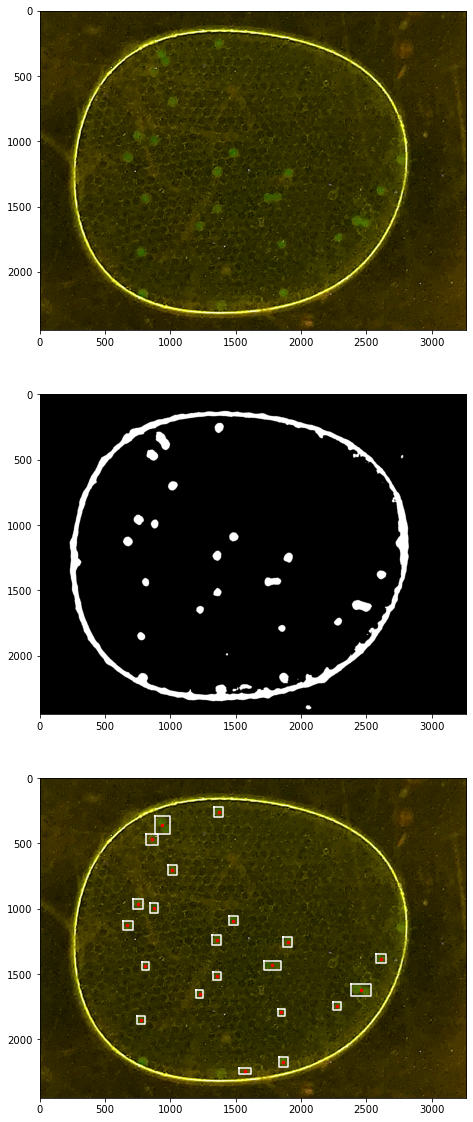

In [120]:
# TESTING

# create labeler instance
labeler = ParticleLabeler()

# read image file
labeler.imread("data/25-camera.jpg")

# make composite channel
labeler.composite({'g':1}, 'k')

# threshold
labeler.threshold(src='k', dst='k', r=41)

# label
labeler.label(src='k')
print(labeler.particle_count)

    
fix, ax = plt.subplots(3, 1, figsize=(12,20))
labeler.imshow(ax[0])
labeler.channels['k'].imshow(ax[1])
labeler.imshow(ax[2])
for p in labeler.particles:
    if p.size() > 50 and p.size() < 150:
        x, y = p.bounding_box()
        ax[2].plot(x, y, 'w')
        ax[2].plot([p.x], [p.y], 'r.', ms=5)

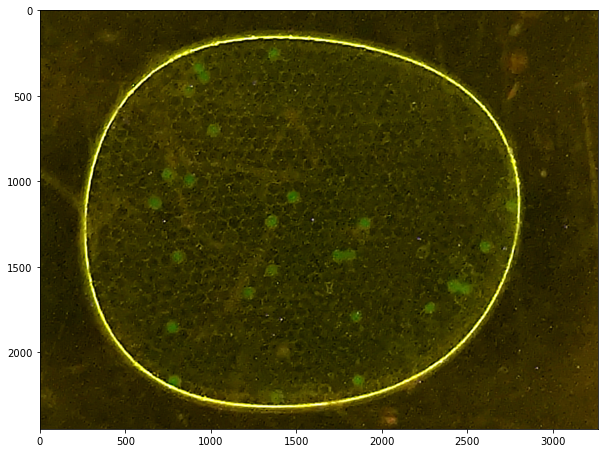

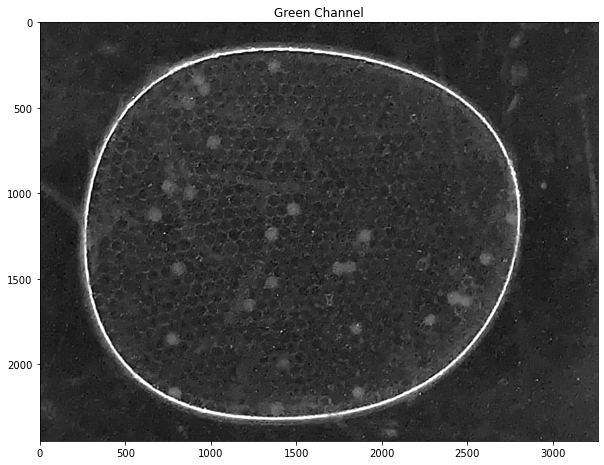

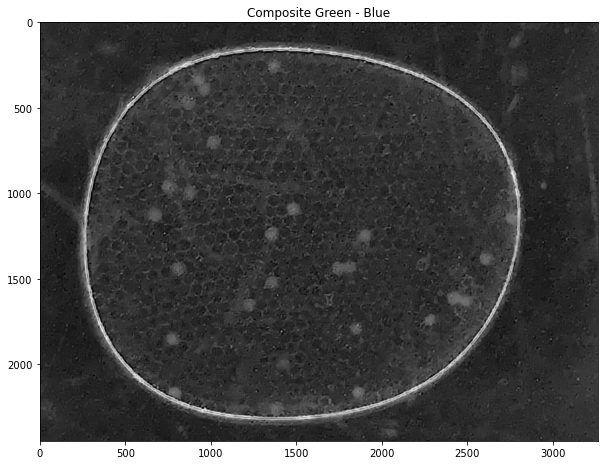

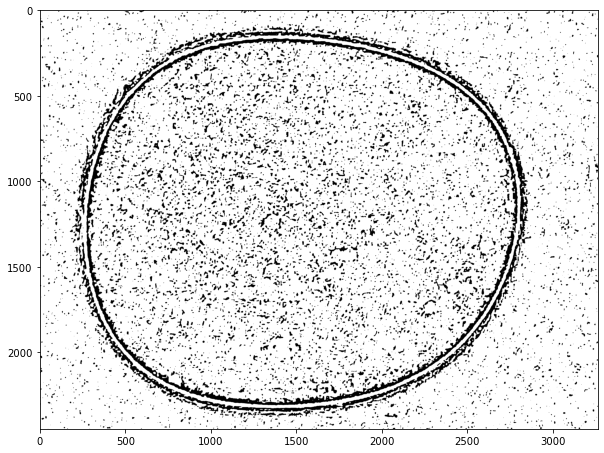

In [108]:
labeler = ParticleLabeler()
labeler.imread("data/25-camera.jpg")
labeler.imshow()
labeler.channels['g'].imshow(title="Green Channel")
labeler.composite({'g':1, 'b':-0.53}, 'k')
labeler.channels['k'].imshow(title="Composite Green - Blue")
labeler.adaptive_threshold(src='g', dst='k2')
labeler.channels['k2'].imshow()

### Thresholding

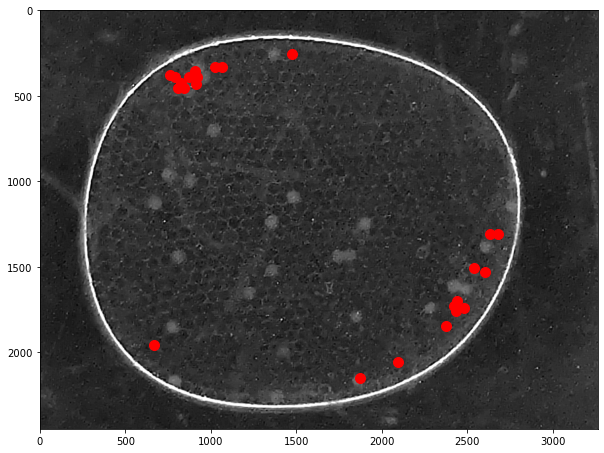

In [110]:
circles = cv.HoughCircles(timg, 
                          cv.HOUGH_GRADIENT, 
                          1.5, 
                          30, 
                          param1=80, 
                          param2=20, 
                          minRadius=50, 
                          maxRadius=200)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))
ax.imshow(img, cmap="gray")

for circle in circles[0]:
    x, y, r = circle
    plt.plot([x], [y], 'r.', ms=20)
    